# MC1 GBSV
## Import

In [8]:
import openmeteo_requests
import requests_cache
from retry_requests import retry
import os
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, ccf
import statsmodels.api as sm
from scipy.signal import correlate
import pandas as pd
import numpy as np

## Anwendungsfall und Problemstellung

**Problemstellung:**  
Die Temperaturen in der Stadt Basel zeigen über längere Zeiträume wiederkehrende Muster, insbesondere durch saisonale Zyklen. Die Analyse dieser Muster ist entscheidend für verschiedene Anwendungsbereiche, wie Klimaforschung, Energieplanung und landwirtschaftliche Vorhersagen.
In dieser Aufgabe untersuche ich, ob und welche periodischen Muster in den Temperaturdaten von Basel über 25 Jahre bestehen. Ich verwende Auto-Korrelation, um wiederkehrende Zyklen zu identifizieren und zu analysieren.

**Ziel der Analyse:**  
1. Erkennen von periodischen Mustern (z. B. Jahreszeiten) in den Temperaturdaten.
2. Quantitative Bestimmung der Periodizität von Temperaturzyklen.
3. Ableitung von möglichen Langzeittrends oder Anomalien.
4. Demonstration der Auto-Korrelationsanalyse anhand eines ausgewählten Abschnitts der Temperaturdaten.

**Auswahl des 1D-Signals**  
Das Signal, das ich untersuche, sind tägliche Durchschnittstemperaturen aus Basel über einen Zeitraum von 25 Jahren. Dieses Signal ist eindimensional (1D), da es sich um eine Zeitreihe handelt, in der Temperaturwerte über die Zeit gemessen wurden.
Ich erwarte, dass sich saisonale Muster mit einer Periodizität von ungefähr 365 Tagen zeigen, da sich die Jahreszeiten wiederholen. Zudem könnten langfristige Trends wie Klimaerwärmung oder ungewöhnliche Wettereinflüsse sichtbar werden.

## Code zum Abrufen der Temperaturdaten von den letzten 25 Jahren in Basel (Muss nur einmal ausgeführt werden, um die Daten in ein CVS zu speichern)


In [11]:
#Dieser Code kann so von der API kopiert werden
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 47.5584,
	"longitude": 7.5733,
	"start_date": "2000-03-10",
	"end_date": "2025-03-10",
	"daily": "weather_code"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()}{response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

							# Process daily data. The order of variables needs to be the same as requested.
daily = response.Daily()
daily_weather_code = daily.Variables(0).ValuesAsNumpy()

daily_data = {"date": pd.date_range(
	start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
	end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = daily.Interval()),
	inclusive = "left"
)}

daily_data["weather_code"] = daily_weather_code

daily_dataframe = pd.DataFrame(data = daily_data)

# Speichern der CSV-Datei
output_dir = "Data"
os.makedirs(output_dir, exist_ok=True)  # Erstelle den Ordner, falls er nicht existiert
csv_path = os.path.join(output_dir, "weather_data.csv")

daily_dataframe.to_csv(csv_path, index=False)

Coordinates 47.5571174621582°N 7.549342155456543°E
Elevation 283.0 m asl
Timezone NoneNone
Timezone difference to GMT+0 0 s


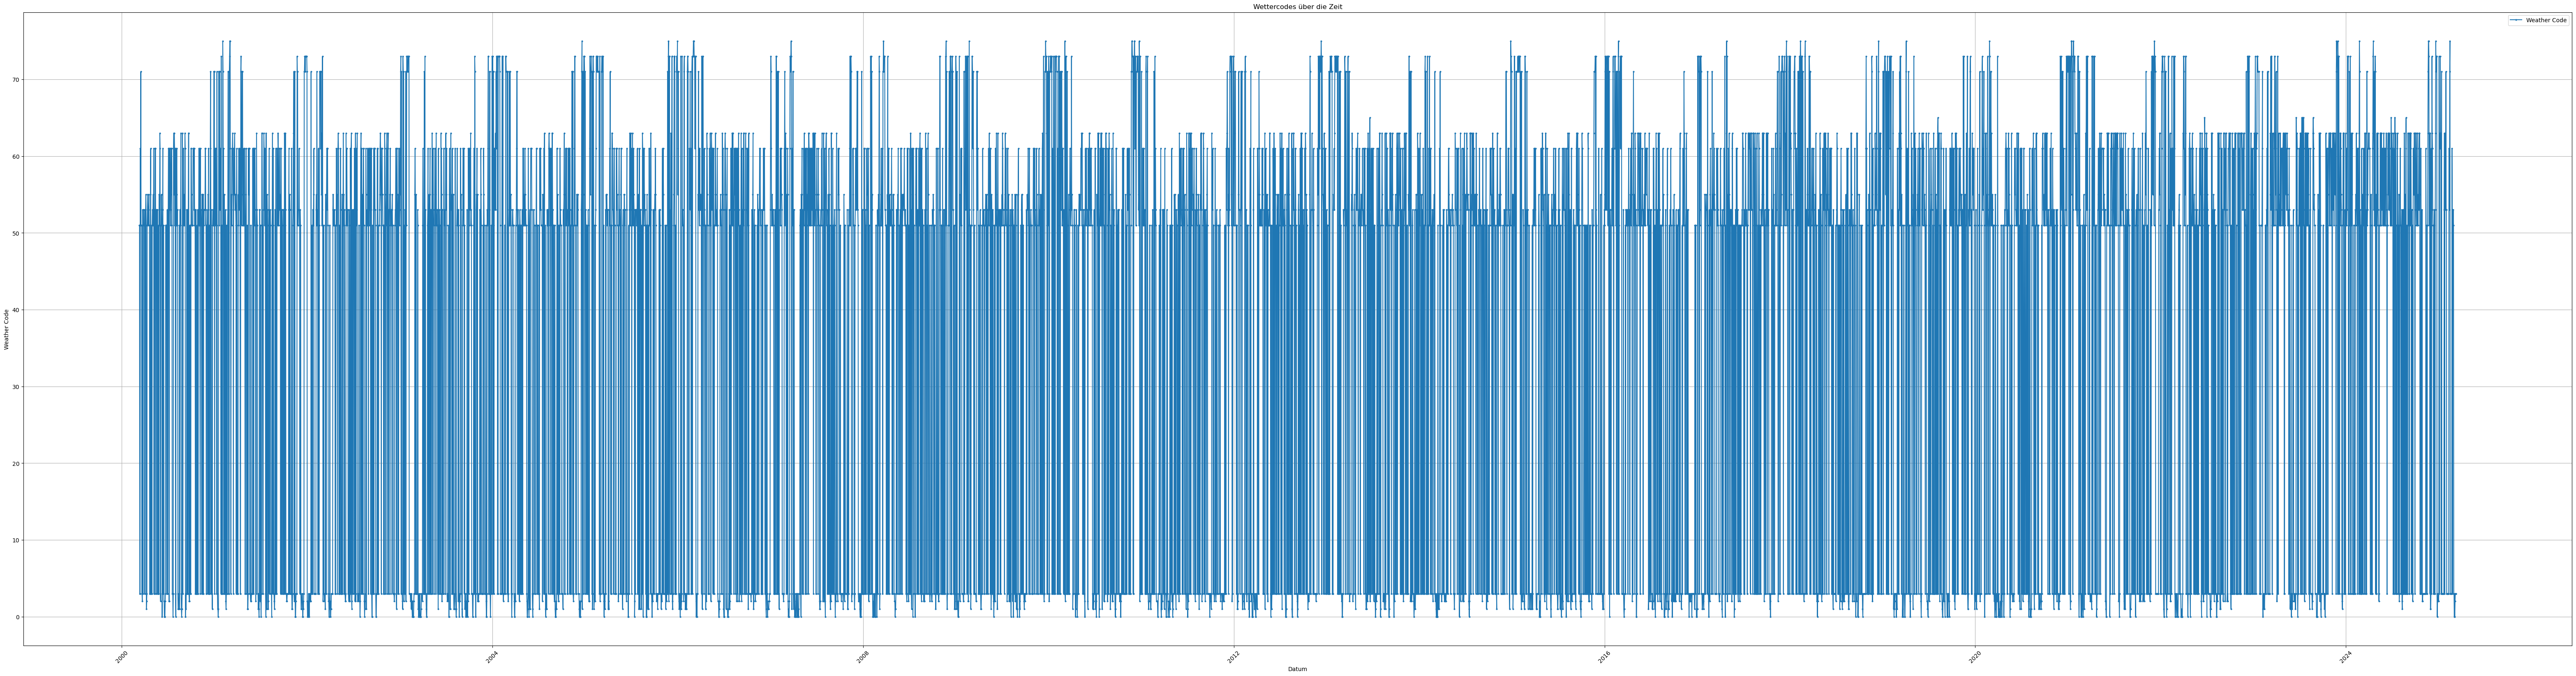

In [22]:
# CSV-Datei laden
csv_path = "C:\\Users\silas\PycharmProjects\GBSV_2025\MC1/Data/weather_data.csv"
if not os.path.exists(csv_path):
    print(f"Fehler: Datei {csv_path} nicht gefunden!")
else:
    daily_dataframe = pd.read_csv(csv_path, parse_dates=["date"])

    # Plot erstellen
    plt.figure(figsize=(80, 20))
    plt.plot(daily_dataframe["date"], daily_dataframe["weather_code"], linestyle="-", marker="o", markersize=2, label="Weather Code")

    # Achsentitel und Beschriftungen
    plt.xlabel("Datum")
    plt.ylabel("Weather Code")
    plt.title("Wettercodes über die Zeit")
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)

    # Plot anzeigen
    plt.show()

# Autokorrelation- Analysieren der Resultate
Die Autokorrelation der Vinci-Aktienkurse zeigt einen Peak bei einem Lag von 5 Tagen, was auf einen möglichen wöchentlichen Zyklus im Aktienkurs hinweist, jedoch muss man bedenken, dass eine Aktie eher grosse Sprünge machen kann. Zudem fallen die Werte jedoch schnell auf nahezu null ab, was darauf hindeutet, dass es keine langfristigen, stabilen periodischen Muster gibt. Der Parameter nlags=256 wurde gewählt, um eine breite Palette von möglichen Mustern zu untersuchen, um beispielsweise auch ein Jahr zu übereinander zu verschieben.

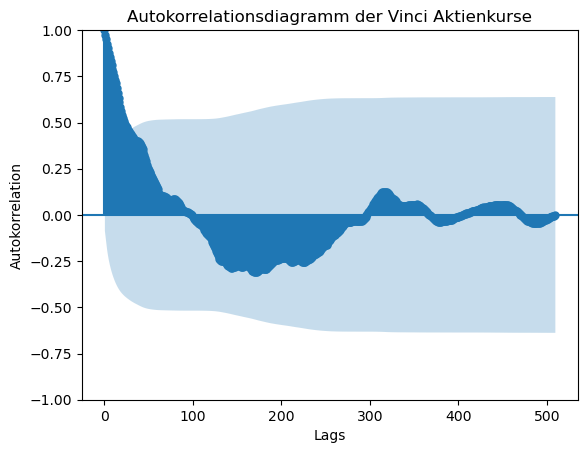

In [3]:
# Nur den Schlusskurs verwenden
close_prices = hist['Close']
# Berechnung der maximalen Anzahl der Lags (Hier bis zum letzten Tag)
lags = len(close_prices) - 1

# Autokorrelationsdiagramm erstellen
sm.graphics.tsa.plot_acf(close_prices, lags=lags, title="Autokorrelationsdiagramm der Vinci Aktienkurse")
plt.xlabel("Lags")
plt.ylabel("Autokorrelation")
plt.show()

# Kreuzkorrelation - Definition eines Anwendungsfalls für Signal Erkennung
## Problemstellung
In unserer Kaffeepause diskutierten wir erneut darüber, dass die Aktienpreise im Januar oft stark fallen und bis März wieder steigen. Dies scheint besonders in diesem Zeitraum der Fall zu sein, da in dieser Zeit berechnet wird, wie viel wir Mitarbeiter für die Aktien zahlen müssen. Ausserhalb dieses Zeitraums tritt eine solche starke Schwankung angeblich nicht auf.

Ich möchte nun überprüfen, ob dieses Muster tatsächlich nur in diesem speziellen Zeitraum auftritt oder ob es auch in anderen Zeiträumen ähnliche Preisschwankungen gibt.

## Warum dieses Stück und wie oft erwarte ich es?
Ich habe den Zeitraum von 01.12.2021 bis 15.03.2022 als Referenz ausgewählt, da dort ein besonders markanter Preisrückgang gefolgt von einer Erholung auftritt. Dieses Segment dient als Muster, das ich im gesamten Datensatz wiederfinden möchte.

Falls das Muster tatsächlich nur durch die Mitarbeiterbeteiligung verursacht wird, sollte ich es in einem 5-Jahres-Datensatz genau fünfmal (einmal pro Jahr) finden. Falls ähnliche Preisschwankungen jedoch auch in anderen Zeiträumen auftreten, könnte das Muster häufiger vorkommen. Ich schätze, dass es ungefähr 100 Mal in den Daten vorhanden sein könnte.

## Erwartung und Interpretation
Sollte das Muster häufiger als fünfmal auftreten, könnte das darauf hindeuten, dass noch andere Faktoren diese Schwankungen beeinflussen. Falls es aber tatsächlich nur fünfmal vorkommt, wäre das ein starkes Indiz dafür, dass es direkt mit der Mitarbeiterbeteiligung zusammenhängt und nicht durch externe Marktfaktoren verursacht wird.

In [4]:
# Vinci SA Aktienkurs für die letzten 5 Jahre abrufen
vinci = yf.Ticker("DG.PA")  # Euronext Paris Börsenkürzel
hist_5y = vinci.history(period="5y")  # Letzte 5 Jahre

# Sicherstellen, dass das Datum im richtigen Format ist
hist_5y['Date'] = hist_5y.index

# Nur benötigte Spalten behalten (Datum, Schlusskurs, Jahr)
hist_5y['Year'] = hist_5y['Date'].dt.year  # Jahr extrahieren

# Speichern der gesamten Datensätze als CSV-Datei im Ordner "Data" mit dem Suffix "_5"
csv_path_5y = "Data/vinci_aktien_5.csv"
hist_5y.to_csv(csv_path_5y, index=False)

print(f"Gefilterte CSV-Datei für 5 Jahre gespeichert: {csv_path_5y}")

Gefilterte CSV-Datei für 5 Jahre gespeichert: Data/vinci_aktien_5.csv


C:\Users\silas\AppData\Local\Temp\ipykernel_4544\569583221.py:5: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  csv_path["Date"] = pd.to_datetime(csv_path["Date"], errors="coerce")


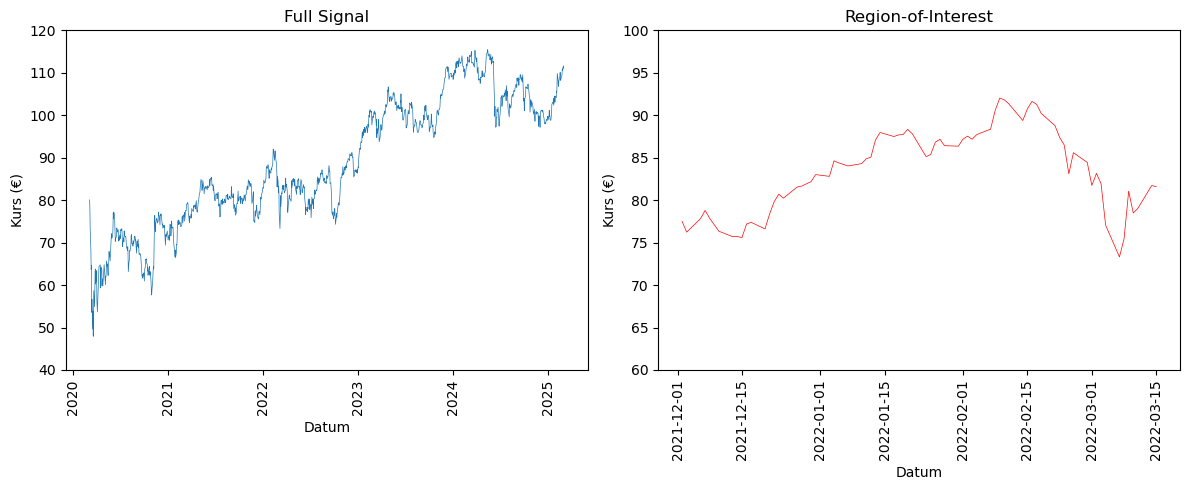

In [5]:
# CSV laden
csv_path = pd.read_csv("Data/vinci_aktien_5.csv")

# Konvertiere die Date-Spalte in datetime und setze sie als Index
csv_path["Date"] = pd.to_datetime(csv_path["Date"], errors="coerce")
csv_path.set_index("Date", inplace=True)

# Definiere das Region of Interest (ROI)
roi = csv_path.iloc[449:523]  # Reihen von 449 bis 523

# Plots erstellen
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Gesamtes Signal
axs[0].plot(csv_path.index, csv_path["Close"], lw=0.5)
axs[0].set_ylim(40, 120)
axs[0].set_title("Full Signal")
axs[0].set_xlabel("Datum")
axs[0].set_ylabel("Kurs (€)")
axs[0].tick_params(axis="x", rotation=90)

# Part of Interest
axs[1].plot(roi.index, roi["Close"], lw=0.5, color="red")
axs[1].set_ylim(60, 100)
axs[1].set_title("Region-of-Interest")
axs[1].set_xlabel("Datum")
axs[1].set_ylabel("Kurs (€)")
axs[1].tick_params(axis="x", rotation=90)


plt.tight_layout()
plt.show()


## Cross-Correlation - Finding the Cut Piece

Anzahl der Übereinstimmungen: 372


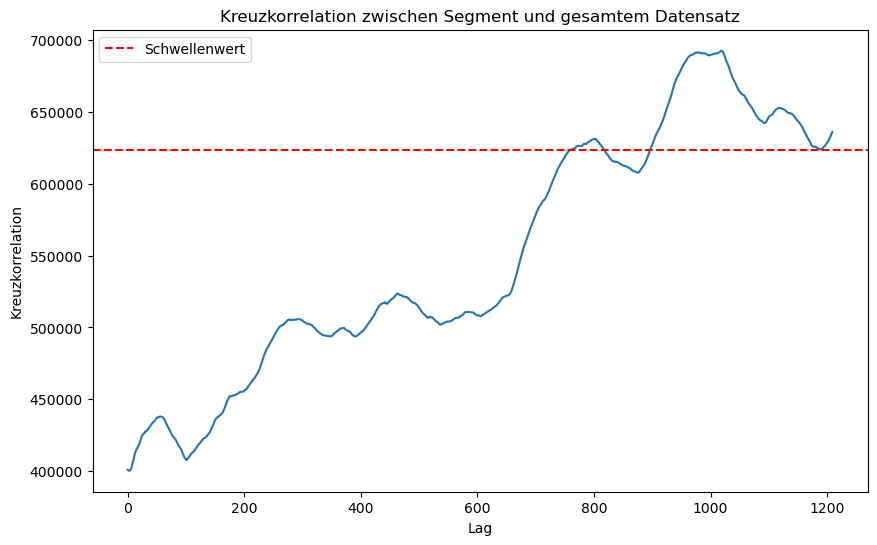

In [6]:
# CSV laden
csv_path = "Data/vinci_aktien_5.csv"  # Dein CSV-Pfad
hist_5y = pd.read_csv(csv_path)

# Konvertiere 'Date' in datetime, falls nicht bereits gemacht
hist_5y['Date'] = pd.to_datetime(hist_5y['Date'], errors='coerce', utc=True)
hist_5y['Date'] = hist_5y['Date'].dt.tz_localize(None)

# Zeitraum von 01.12.2021 bis 15.03.2022 extrahieren
start_date = pd.Timestamp('2021-12-01')
end_date = pd.Timestamp('2022-03-15')

segment = hist_5y[(hist_5y['Date'] >= start_date) & (hist_5y['Date'] <= end_date)]

# Gesamtwerte aus dem Datensatz für die Kreuzkorrelation
whole_signal = hist_5y['Close'].values  # Das komplette Signal, das untersucht wird

# Segmentwerte (Close-Preise des interessierenden Abschnitts)
segment_values = segment['Close'].values

# Suche nach Übereinstimmungen im gesamten Datensatz
correlation_threshold = 0.9  # Beispiel-Schwellwert für die Korrelation (du kannst ihn anpassen)

# Kreuzkorrelation zwischen Segment und gesamtem Signal berechnen
cross_correlation = np.correlate(whole_signal, segment_values, mode='valid')

# Finde Indizes, bei denen die Kreuzkorrelation den Schwellwert überschreitet
matching_indices = np.where(cross_correlation >= correlation_threshold * np.max(cross_correlation))[0]

# Ausgabe der Indizes, an denen Übereinstimmungen auftreten
print(f"Anzahl der Übereinstimmungen: {len(matching_indices)}")

# Plotten der Kreuzkorrelation
plt.figure(figsize=(10, 6))
plt.plot(cross_correlation)
plt.axhline(y=correlation_threshold * np.max(cross_correlation), color='r', linestyle='--', label='Schwellenwert')
plt.title('Kreuzkorrelation zwischen Segment und gesamtem Datensatz')
plt.xlabel('Lag')
plt.ylabel('Kreuzkorrelation')
plt.legend()
plt.show()